**$T_1.$** Soit $X_1$, ..., $X_n$ des variables aléatoires iid de loi $\mathcal{N}(\theta, 1)$, où $\theta$ est inconnu.
1.  (a) Montrer que $\widehat{\theta_n} = \frac{1}{n} \sum\limits_{k=1}^{n}X_k$ converge presque sûrement vers $\theta$.
    
    (b) Déterminer la loi de $\sqrt{n}(\widehat{\theta_n} - \theta)$.
1. Soit $\alpha$ $\in$ $]0, \;1[$ fixé et $\Phi$ la fonction répartition de la loi Gaussienne $\mathcal{N}(\theta, 1)$. Déterminer en fonction de $\alpha$, de $n$, de $\Phi^{-1}$ et de $\theta_0$ la valeur optimale de $K_\alpha$ pour que la relation $\mathbb{P}_{\theta = \theta_0}(T_K=1) \leq \alpha$ soit satisfaite avec une égalité.


Solution:

1. (a) Les $X_i$ sont indépendantes, iid et intégrables, donc la loi forte des grands nombres stipule que $\widehat{\theta_{n}} = \frac{1}{n}\sum_{i=1}^{n} X_i $ converge presque sûrement vers $E(X_1) = \theta $.

   (b) $\widehat{\theta_{n}}$ suit une loi normale $\mathcal{N}(\theta,\,\frac{1}{n})$ comme combinaison linéaire de variables gaussiennes indépendantes $\frac{1}{n}X_i$, donc $\sqrt{n}(\widehat{\theta_{n}} - \theta) = \frac{\widehat{\theta_{n}} - E(\widehat{\theta_{n}})}{\sigma(\widehat{\theta_{n}})}$ suit une loi normale centrée réduite.

1. On cherche $K_{\alpha}$ tel que $P_{\theta = \theta_{0}}(1_{(\widehat{\theta_{n}} < K_{\alpha})} = 1 ) = P_{\theta = \theta_{0}}(\widehat{\theta_{n}} < K_{\alpha}) = \alpha$ i.e $$P_{\theta = \theta_{0}}(\sqrt{n}(\widehat{\theta_{n}} - \theta) < \sqrt{n}(K_{\alpha} - \theta_{0})) = \alpha $$ c'est-à-dire : $$ \Phi(\sqrt{n}(K_{\alpha} - \theta_{0}))= \alpha$$ d'où $$K_{a} = \frac{1}{\sqrt{n}}\Phi(\alpha)^{-1} + \theta_{0} $$

**$T_2$.** Soit $(X_1, X_2, X_3)$ trois variables aléatoires indépendantes, calculer pour tout $(i, j) \in {1, 2, 3}^2$
$\mathbb{E}[Y |X_i]$ et $\mathbb{E}[Y |X_i, X_j]$ lorsque

1. $Y = f(X_1, X_2, X_3) = aX_1 + X_2 + X_3 + bX_2X_3$ où $a$ et $b$ sont deux paramètres réels et les $X_i$ sont de lois gaussiennes $\mathcal{N}(0, 1)$.

1. $Y = g(X_1, X_2, X_3) = sin X_1 + 7 sin^2 X_2 + 0.1X^4_3 sin X_1$ où les $X_i$ sont de lois uniformes sur $[-\pi, \pi]$.

1. $Y = h(X_1, X_2, X_3) = exp(X_1 + 2X_2 + aX_3)$ où $a$ est un paramètre réel et les $X_i$ sont de lois gaussiennes $\mathcal{N}(0, 1)$.

Solution:

1.  $Y = f(X_1,X_2,X_3) = aX_1 + X_2 + X_3 + bX_2X_3$ :

    **Calcul de $E(Y|X_{1})$ :**

    $E(Y|X_{1}) =  E(X_{2} + X_{3} + bX_{2}X_{3} | X_{1}) + aE(X_{1} | X_{1}) $


    $X_{1}, X_{2}, X_{3}$ sont indépendantes, donc par le lemme des coalisées, $X_{2} + X_{3} + bX_{2}X_{3}$ et $X_{1}$ sont indépendantes, et puisque $E(X|X) = X$, on a : $$E(Y|X_{1}) = E(X_{2} + X_{3} + bX_{2}X_{3}) + aX_{1} = E(X_{2}) + E(X_{3}) + bE(X_{2})E(X_{3}) + aX_{1} = aX_{1}  $$
    
    **Calcul de $E(Y|X_{2})$ :**
    
    
    \begin{align*}
        E(Y|X_{2}) &= X_{2} E((1 + bX_{3}) | X_{2}) + E(X_{3} | X_{2}) + aE(X_{1} | X_{2}) \\
        &= X_{2}E(1 + bX_{3}) + E(X_{3}) + aE(X_{1}) \quad \text{(car \(1 + bX_{3}\) et \(X_{2}\) sont indépendantes)}
    \end{align*}
    Ainsi : $$ E(Y|X_{2}) = X_{2} $$
    
    **Calcul de $E(Y|X_{3})$ :**
    Par symétrie de $X_{2}$ et $X_{3}$, $E(Y|X_{3}) = X_{3}$
    
    
    **Calcul de $E(Y|X_{1},X_{2})$ :**
    
    
    $E(Y|X_{1},X_{2}) = aE(X_{1}| X_{1},X_{2}) + E(X_{2}| X_{1},X_{2}) + E(X_{3}| X_{1},X_{2}) + bE(X_{2}X_{3}| X_{1},X_{2})$
    
    
    En posant $g_{1} : (x,y) \longmapsto x$, et $g_{2} : (x,y) \longmapsto y$ on a, de par l'indépendance de $X_{3}$ et $(X_{1},X_{2})$ :
    \begin{align*}
        E(Y|X_{1}, X_{2}) &= aE(g_{1}(X_{1}, X_{2}) \cdot 1| X_{1}, X_{2}) 
        + E(g_{2}(X_{1}, X_{2}) \cdot 1| X_{1}, X_{2}) \\
        &\quad + E(X_{3}) 
        + bE(g_{2}(X_{1}, X_{2})X_{3}| X_{1}, X_{2}) \\
        &\quad  \\
        &= ag_{1}(X_{1}, X_{2})E(1| X_{1}, X_{2}) 
        + g_{2}(X_{1}, X_{2})E(1| X_{1}, X_{2}) \\
        &\quad + E(X_{3}) 
        + bg_{2}(X_{1}, X_{2})E(X_{3})
    \end{align*}
    D'où : $$E(Y|X_{1},X_{2}) = a X_{1}+ X_{2}$$
    
    **Calcul de $E(Y|X_{2},X_{3})$ :**
    
    $$E(Y|X_{2},X_{3}) = X_{2} + X_{3} + bX_{2}X_{3}$$
    
    **Calcul de $E(Y|X_{1},X_{3})$ :**
    Par symétrie de $X_{2}$ et $X_{3}$ :
    $$E(Y|X_{1},X_{3}) = a X_{1}+ X_{3} $$

1. Y = g(X_1,X_2,X_3) = \sin(X_1) + 7 \sin(2 X_2) + 0.1 X_3 \sin(X_1)
   **Calcul de $E(Y|X_{1})$ :** Par indépendance de $sin(X_{1}), sin^{2}(X_{2}), X^{4}_{3}$
   $$E(Y|X_{1})= sin(X_{1})E(1|X_{1}) + 7E(sin^{2}(X_{2})) + 0.1sin(X_{1})E(X^{4}_{3})$$
   $X^{4}_{3}$ a une densité de $\frac{1}{4\pi u^{\frac{3}{4}}}$, d'où une espérance $E(X^{4}_{3}) = \frac{\pi^{4}}{5}$
  

   $E(sin^{2}(X_{2})) = \frac{1}{2}$ ainsi : 
   $$E(Y|X_{1}) = (1 +\frac{\pi^{4}}{50})sin(X_{1}) + \frac{7}{2}$$
   
   **Calcul de $E(Y|X_{2})$ :**
   $$E(Y|X_{2}) = E(sin(X_{1})) + 7sin^{2}(X_{2}) + 0.1E(sin(X_{1}))E(X^{4}_{3})$$
   $sin(X_{1})$ a une densité de $\frac{1}{\pi \sqrt{1 - u^{2}}}\mathbb{1}_{[-1,1]}$ d'où une espérance $E(sin(X_{1}) = \displaystyle \int_{-1}^{1}\frac{x}{\sqrt{\pi(1-x^{2})}}dx = \displaystyle \int_{-\frac{\pi}{2}}^{\frac{\pi}{2}}\frac{sin(u)}{\pi} du = 0 $ grâce au changement de variable $x = sin(u)$. 
   D'où : $$E(Y|X_{2}) = 7sin^{2}(X_{2})) $$
   
   
   **Calcul de $E(Y|X_{3})$ :**
   
   $$ E(Y|X_{3}) = E(sin(X_{1})) + 7E(sin^{2}(X_{2})) + 0.1X^{4}_{3}E(sin(X_{1}))$$
   $$E(Y|X_{3}) = \frac{7}{2} $$
   
   **Calcul de $E(Y|X_{1},X_{2})$ :**
   $$E(Y|X_{1},X_{2}) = sin(X_{1}) + 7sin^{2}(X_{2}) + 0.1sin(X_{1})E(X^{4}_{3})$$
   $$E(Y|X_{1},X_{2}) = (1 + \frac{\pi^{4}}{50})sin(X_{1}) + 7sin^{2}(X_{2}) $$
   
   **Calcul de $E(Y|X_{1},X_{3})$ :**
   $$E(Y|X_{1},X_{3}) = sin(X_{1})(1 + 0.1X^{4}_{3}) + \frac{7}{2}$$
   
   **Calcul de $E(Y|X_{2},X_{3})$ :**
   $$E(Y|X_{2},X_{3}) = 7sin^{2}(X_{2})$$

1. $Y = h(X_1,X_2,X_3) = \exp(X_1 + 2X_2 + aX_3)$ :

   **Calcul de $E(Y|X_{1})$ :** Par indépendance de $exp(X_{1})$, $exp(2X_{2})$ et $exp(aX_{3})$ :
   $$E(Y|X_{1}) = \exp{(X_{1})}E(\exp{(2X_{2})}E(\exp{(aX_{3}}))$$
   
   
   $\exp{(aX_{3})}$ a une densité $\frac{e^{-\frac{ln(u)^{2}}{2a^{2}}}}{\sqrt{2\pi}au}\mathbb{1}_{\text{R}_{+}^{*}}$ d'où une espérance $E(\exp{(aX_{3})}) = \frac{1}{\sqrt{2\pi}}\displaystyle \int_{0}^{+\infty} \frac{e^{-\frac{ln(u)^{2}}{2a^{2}}}}{a}du =\frac{1}{\sqrt{2\pi}}\frac{e^{\frac{a^{2}}{2}}}{a} \displaystyle \int_{_\infty}^{+\infty}e^{-\frac{(x-a^{2})^{2}}{2a^{2}}} dx = e^{\frac{a^{2}}{2}}$ grâce au changement de variable $u = e^{x}$.
   
   On a donc aussi $E(\exp{(2X_{2})}) = e^{2}\sqrt{2\pi} $  et $E(\exp{(X_{1})}) = \sqrt{2\pi e}$ 
   Ainsi :
   $$E(Y|X_{1}) = \exp{(X_{1} + \frac{a^{2}}{2} + 2)}$$
   
   **Calcul de $E(Y|X_{2})$ :**
   
   $$E(Y|X_{2}) =  \exp{(2X_{2} + \frac{a^{2} + 1}{2} )} $$
   
   **Calcul de $E(Y|X_{3})$ :** 
   
   $$E(Y|X_{3}) =  \exp{(aX_{3} + \frac{5}{2})} $$
   
   **Calcul de $E(Y|X_{1},X_{2})$ :**
   
   $$E(Y|X_{1},X_{2}) = \exp{(X_{1} + 2X_{2} + \frac{a^{2}}{2})} $$
   
   **Calcul de $E(Y|X_{1},X_{3})$ :**
   
   $$E(Y|X_{1},X_{3}) = \exp{(X_{1} + aX_{3} + 2)} $$
   
   **Calcul de $E(Y|X_{2},X_{3})$ :**
   
   $$E(Y|X_{2},X_{3}) = \exp{(2X_{2} + aX_{3} + \frac{1}{2})} $$


**$T_3$.** Dans la suite du projet si $w \subset \{1, 2, ..., p\}$, l’ensemble des $\{X_i, i \in w\}$ sera noté par $X_w$.

1. Soit $w \subset \{1, 2, ..., p\}$ et notons $\sim w$ le complémentaire de $w$ dans $\{1, 2, ..., p\}$ en remarquant que

   $Y = E [Y] + (E[Y | X_w] − E[Y]) + (E[Y|X_{\sim w}] − E[Y]) + Y −(E[Y] + (E[Y |X_w] −E[Y]) + (E[Y|X_{\sim w}] − E[Y]))$
   
   montrer que
   
   $Var(Y) = Var(E[Y |X_w]) + Var(E[Y |X_{\sim w}]) + Var(Y − E[Y |X_w] −E[Y |X_{\sim w}])$.

1. En déduire que $0 \leq S_w \leq 1$.

1. Soit maintenant $v \subset u \subset \{1, 2, ..., p\}$. D’après le résultat de Doob on sait qu’il existe une fonction $g$ telle que $E[Y |X_u] = g(X_u)$. En appliquant (9.3) et (9.4) à la fonction $g$ en remplaçant $\{1, ..., p\}$ par $u$ et $w$ par $v$ montrer que $Sv \leq Su$.


Solution:

1. Posons A = $E[Y \mid X_w] + E[Y \mid X_{\sim w}]$, on a $Var(A)= Var(E[Y \mid X_w]) + Var(E[Y \mid X_{\sim w}])$, par indépendance de de $E[Y \mid X_w]$ et $E[Y \mid X_{\sim w}]$ issue de l'indépendance des  $X_{i}$.

   En utilisant $Y = A + (Y - A)$ on obtient :
   
   $Var(Y) = Var(A) + Var(Y-A) + 2 Cov(A, Y - A) = Var(A) + Var(Y-A) + 2 Cov(A, Y) - 2 Var(A)$
   
   
   or $Cov(A, Y) = Cov(Y, E[ Y \mid X_w]) + Cov(Y, E[Y \mid X_{\sim w}] = E[Y \cdot E[ Y \mid X_w]] - E[Y]\cdot E[E[ Y \mid X_w]] + E[Y \cdot E[ Y \mid X_{\sim w}]] - E[Y]\cdot E[E[ Y \mid X_{\sim w}]]$, 
   
   D'après le résultat de Dood, $E[ Y \mid X_w]$ est une fonction mesurable de $X_w$, ce qui nous donne, grâce à la définition de l'espérance conditionnelle, que : $E[Y \cdot E[ Y \mid X_w]] = E[E[ Y \mid X_w ]E[ Y \mid X_w ]] = E[E[ Y \mid X_w ]^{2}]$.
   
   
   De même, $E[Y \cdot E[ Y \mid X_{\sim w}]] = E[E[ Y \mid X_{\sim w} ]^{2}]$
   
   Ainsi : $Cov(A, Y) = Var(E[ Y \mid X_w] + Var( E[Y \mid X_{\sim w}]) = Var(A)$
   
   Finalement : 
   
   $Var(Y) = Var(A) + Var(Y-A) =  Var(E[Y \mid X_w]) + Var(E[Y \mid X_{\sim w}]) + Var(Y-(E[Y \mid X_w] + E[Y \mid X_{\sim w}]))$

1. La variance est positive donc $S_u$ est positive comme quotient de deux variances (il faut que $Var(Y) \neq 0$)

   Avec (9.4), $1 = S_w + S_{\sim w}+ Var(Y-(E[Y \mid X_w] + E[Y \mid X_{\sim w}])) \geq S_w $
   Donc $$0 \leq S_w \leq 1  $$

1. Il existe une fonction mesurable $g$ telle que $E[Y | X_u] = g(X_u)$
   On a, d'après le théorème de la variance totale (formule de décomposition de la variance) : $$Var(g(X_u)) = E[Var(X_u | X_v)] + Var(E[g(X_u) | X_v])$$
   Or $X_v$ est un sous-vecteur de $X_u$ donc $E[Y | X_v] = E[E[Y | X_u ] | X_v] = E[g(X_u) | X_v]$
   Ainsi, en divisant par $Var(Y)$ :
   $$S_u = \frac{E[Var(X_u | X_v)]}{Var(Y)} + S_v$$
   
   Par positivité de la variance et de la variance conditionnelle $Var(X_u | X_v) = E[(X_u - E[X_u])^{2} | X_v]$ (issue de la positivité de l'espérance conditionnelle), on a :
   $$S_u \geq S_v$$

**$T_4$.** Montrer que

$Var(E[Y |X_i, i \in u]) = Cov(f(X_1, X_2, ..., X_p), f(X^u_1 , X^u_2 , ..., X^u_p ))$

où $X^u_i = X_i$ si $i \in u$ et $X^u_i = X'_i$ sinon

Solution:

$Y$ et $f(X_1^{u}, ..., X_p^{u})$ sont de même loi donc ont la même espérance :


$Cov(Y, f(X_1^{u}, ..., X_p^{u}) ) = E[Yf(X_1^{u}, ..., X_p^{u})] - E[Y]^{2} = E[E[Yf(X_1^{u}, ..., X_p^{u})|X_u]] - E[E[Y | X_u]]^2$.


Puisque $f(X_1^{u}, ..., X_p^{u})$ dépend de \{$X_{i}', \text{ pour } i \notin u$\} et \{$X_{i}, \text{ pour } i \in u$\} et que $Y$ dépend de \{$X_{i}, \text{ pour } i \notin u$\} et \{$X_{i}, \text{ pour } i \in u$\}, on a par indépendance de $X_i'$ et $X_j$ que $f(X_1^{u}, ..., X_p^{u})$ et $Y$ sont "indépendantes sachant" \{$X_{i}, \text{ pour } i \in u$\}.
Cela nous permet d'écrire que l'espérance conditionnelle sachant \{$X_{i}, \text{ pour } i \in u$\} de leur produit est égale au produit de leurs espérances conditionnelles sachant \{$X_{i}, \text{ pour } i \in u$\} :

$E[E[Yf(X_1^{u}, ..., X_p^{u})|X_u]] = E[E[Y | X_{u} ]E[f(X_1^{u}, ..., X_p^{u})|X_u]] = E[E[Y | X_{u} ]^{2}] $
Donc : $$ Cov(Y, f(X_1^{u}, ..., X_p^{u}) ) = Var(E[Y | X_{u} ])$$  

**$T_5$.** Loi forte des grands nombres: Montrer que les estimateurs sont consistants i.e. le vecteur
$(S^u_n, S^v_n)$ converge presque sûrement vers $(S_u, S_v)$.

Solution:

Toutes les variables étant intégrables, par la loi forte des grands nombres :
$$\frac{1}{n}\sum_{i=1}^{n} Y_{k}^{2} \xrightarrow[]{p.s} E[Y^{2}]$$ 
$$(\frac{1}{n}\sum_{i=1}^{n} Y_{k})^2 \xrightarrow{p.s} E[Y]^2$$
$$\frac{1}{n} \sum_{i=1}^{n} Y_{k}^{u} \xrightarrow{p.s} E[f(X_{1}^{u}, ..., X_{p}^{u})] $$
Avec l'indépendance de $(Y_{k} Y_{k}^{u})_{1 \leq k \leq n}$ :
$$\frac{1}{n} \sum_{i=1}^{n} Y_{k} Y_{k}^{u} \xrightarrow{p.s} E[Yf(X_{1}^{u}, ..., X_{p}^{u})]$$

Donc $$S_{k}^u = \frac{\frac{1}{n} \sum_{i=1}^{n} Y_{k} Y_{k}^{u} - (\frac{1}{n}\sum_{i=1}^{n} Y_{k}) \cdot \frac{1}{n} \sum_{i=1}^{n} Y_{k}^{u} }{\frac{1}{n}\sum_{i=1}^{n} Y_{k}^{2} - (\frac{1}{n}\sum_{i=1}^{n} Y_{k})^2 } \xrightarrow[]{p.s} \frac{Cov(Y, f(X_{1}^{u}, ..., X_{p}^{u})) }{Var(Y)} = S_{u}$$

De même pour $S_{k}^v$ : 
$$ S_{k}^v \xrightarrow{p.s} S_{v} $$ 

Les estimateurs $S_{k}^u$ et $S_{k}^v$ sont consistants.

**$T_6$.** Soit $(Z_k)_{k > 1}$ des vecteurs aléatoires i.i.d. de $\mathbb{R}^k$ de moyenne $\theta$ et de matrice de covariance $\Sigma$. 

Appliquer le Théorème central limite vectoriel aux vecteurs $Z_k$ et en déduire la loi limite de

$\sqrt{n} \left( \phi \left( \frac{1}{n} \sum_{k=1}\limits^n Z_k \right) - \phi(\theta) \right)$.

Solution:

Soient $r_n = \sqrt{n} \xrightarrow{n \rightarrow \infty} \infty$ et l'application $\phi: \mathbb{R}^k \rightarrow \mathbb{R}^m$ differentiable en $\theta$ .

D'après le Théorème Central Limite:

$$r_n\left(\frac{1}{n}\sum\limits_{k=1}^{n}Z_k - \theta\right) = \sqrt{n}\left(\frac{1}{n}\sum\limits_{k=1}^{n}Z_k - \theta\right) \xrightarrow[n \rightarrow \infty]{\mathcal{L}} \mathcal{N}(0, \Sigma) $$

Alors, on peut appliquer la Méthode Delta pour $\phi$:

$$\sqrt{n}\left(\phi \left(\frac{1}{n}\sum\limits_{k=1}^{n}Z_k\right) - \phi(\theta)\right) \xrightarrow[n\rightarrow \infty]{\mathcal{L}} \mathcal{N}(0, J_{\phi}(\theta)\Sigma J_{\phi}^T(\theta))$$

Où $J_{\phi}(\theta)$ est la matrice Jacobienne de $\phi$ en $\theta$.

**$T_7$**. Théorème central limite: L’objectif de cette question est de montrer que si $\mathbb{E}[Y^4] $ existe alors les estimateurs sont asymptotiquement normaux i.e.
$
\sqrt{n} \left( (S_{\mathbf{u}}^{(n)}, S_{\mathbf{v}}^{(n)}) - (S_{\mathbf{u}}, S_{\mathbf{v}}) \right)$ converge en loi vers un vecteur gaussien centré de dimension 2. Puis d’expliciter la matrice de covariance $\Gamma$

1. Appliquer le théorème central limite vectoriel au vecteur aléatoire $\mathbb{R}^6$

   $$Z_k = (Y_k, Y_k^{(u)}, Y_k^{(v)}, Y_kY_k^{(u)}, Y_kY_k^{(v)}, Y_k^{2})$$
   et déterminer le vecteur $m$ et la matrice $\Sigma$ telle que
   $$\sqrt{n} \left( \frac{1}{n}\sum_{k = 1}^{n}Z_k - m  \right) \xrightarrow[]{\mathcal{L}} \mathcal{N}_{6}(0 , \Sigma)$$
   
1. Conclure en appliquant la delta méthode à la fonction $\phi$ de $\mathbb{R}^6$ dans $\mathbb{R}^2$ définie par

   $\phi(x_1, x_2, \ldots, x_6) = 
   \left( \frac {x_4 - x_1 x_2}{x_6 - x_1^2},
   \frac{x_5 - x_1 x_3}{x_6 - x_1^2}\right)
   $

1. Exprimer $\Gamma$ en fonction de $\Sigma$ et de la matrice Jacobienne de $\phi$.

Solution:

1.  On pose $Y^{u} = f(X_1^{u}, ... , X_p^{u})$ et $Y^{v} = f(X_1^{v}, ... , X_p^{v})$
    $Y$ et $f(X_{1}^{u}, ..., X_{p}^{u})$ admettent un moment d'ordre $4$ donc $Y_k, Y_k^{u}, Y_k^{v}$ et $Y_k^{2}$ admettent une variance donc le vecteur $Z_k$ admet une variance $\Sigma$ = 
    
    \begin{pmatrix}
        Var(Y) & \text{Cov}(Y, Y^u) & \text{Cov}(Y, Y^{v}) & \text{Cov}(Y, YY^u) & \text{Cov}(Y, Y Y^{v}) & \text{Cov}(Y, Y^{2}) \\
    \text{Cov}(Y^u, Y) & Var(Y) & \text{Cov}(Y^u,Y^{v}) & \text{Cov}(Y^u, Y Y^u) & \text{Cov}(Y^u, Y Y^{v}) & \text{Cov}(Y^u, Y^{2}) \\
    \text{Cov}(Y^{v}, Y) & \text{Cov}(Y^{v}, Y^u) & Var(Y) & \text{Cov}(Y^{v}, YY^u) & \text{Cov}(Y^{v}, Y Y^{v}) & \text{Cov}(Y^{v}, Y^{2}) \\
    \text{Cov}(YY^u, Y) & \text{Cov}(YY^u, Y^u) & \text{Cov}(YY^u, Y^{v}) & \text{Var}(YY^u) & \text{Cov}(YY^u, YY^{v}) & \text{Cov}(YY^u, Y^{2}) \\
    \text{Cov}(YY^{v}, Y) & \text{Cov}(YY^{v}, Y^u) & \text{Cov}(YY^{v}, Y^{v}) & \text{Cov}(YY^{v}, YY^u) & \text{Var}(YY^{v}) & \text{Cov}(YY^{v}, Y^{2}) \\
    \text{Cov}(Y^{2}, Y) & \text{Cov}(Y^{2}, Y^u) & \text{Cov}(Y^{2}, Y^{v}) & \text{Cov}(Y^{2}, YY^u) & \text{Cov}(Y^{2}, YY^{v}) & Var(Y^{4})
    \end{pmatrix} 
    
     et son espérance est $m = \begin{bmatrix}
    E[Y] \\
    E[Y^{u}] \\
    E[Y^{v}] \\
    E[Y \cdot Y^{u}] \\
    E[Y \cdot Y^{v}] \\
    E[Y]^{2}
    \end{bmatrix}$, donc le théorème central limite donne :
    $$ \sqrt{n} \left( \frac{1}{n}\sum_{k = 1}^{n}Z_k - m  \right) \xrightarrow[n\rightarrow \infty]{\mathcal{L}} \mathcal{N}_{6}(0 , \Sigma) $$
  
1. $\phi(\frac{1}{n}\sum_{k = 1}^{n}Z_k ) = ( S_{n}^{u}, S_{n}^{v} ) $ et $\Phi(m) = (S_u, S_v)$ donc par la méthode Delta $$\sqrt{n} \left( \phi(\frac{1}{n}\sum_{k = 1}^{n}Z_k ) - \phi(m) \right) \xrightarrow[n\rightarrow \infty]{\mathcal{L}} \mathcal{N}_{2}(0, J_\phi(m) \Sigma J_\phi(m)^{T})$$ i e

   $$\sqrt{n}(( S_{n}^{u}, S_{n}^{v} ) - (S_u, S_v)) \xrightarrow[n\rightarrow \infty]{\mathcal{L}} \mathcal{N}_{2}(0,\Gamma)  $$ 

1. $$\Gamma = J_\phi(m) \Sigma J_\phi(m)^{T}$$ 
  
  avec : $$J_\phi(m) = \frac{1}{Var(Y)}
  \begin{pmatrix}
      E[Y]\cdot (2S_u - 1) & -E[Y] & 0 & 1 & 0 & -S_u \\
      E[Y]\cdot (2S_v - 1) & 0 & -E[Y] & 0 & 1 & -S_v
  \end{pmatrix}$$

**$T_8$.** Montrer lorsque $H_0$ est vraie que la loi limite de $\sqrt{n}(S^u_n−S^v_n)$ est une gaussienne centrée. Exprimer la variance $\sigma^2$ de cette gaussienne en fonction de la matrice $\Gamma$.

Solution:

Supposons $H_0$ vraie, alors $S_v = S_u$
On introduit $g : (x,y) \mapsto x - y$ de Jacobienne $J_g = 
\begin{pmatrix}
    1 & -1 \\
\end{pmatrix}$

Par la méthode Delta $\sqrt{n}(g( S_{n}^{u}, S_{n}^{v} ) - g(S_u, S_v)) \xrightarrow[n\rightarrow \infty]{\mathcal{L}} \mathcal{N}_{2}(0,J_g\Gamma J_g^{T}) $ i.e
$$\sqrt{n}(S_u^{n} - S_v^{n})\xrightarrow[n\rightarrow \infty]{\mathcal{L}} \mathcal{N}_{2}(0, \sigma^{2}) $$

avec une variance $\sigma^{2} = \begin{pmatrix}
    1 & -1 \\
\end{pmatrix} \Gamma \begin{pmatrix}
    1 \\
    -1
\end{pmatrix}  = Tr(\Gamma) - 2\Gamma_{1,2} $

**$T_9$.** Déterminer la valeur optimale de $K$ pour laquelle la règle de décision $T_K = 1_{\{\widehat{S_u} - \widehat{S_v} < K\}}$ vérifie la propriété (9.1). On prendra $\alpha = 0.05$.

Solution:

En notant $\widehat{\sigma_{n}^2}$ l'estimateur de la variance $\sigma^{2} = \begin{pmatrix}
    1 & -1 \\
\end{pmatrix} \Gamma \begin{pmatrix}
    1 \\
    -1
\end{pmatrix} $, la valeur optimale de K vérifie :

$P(S_u^{n} - S_u^{n} < K) = 0,05$ i.e $P(\sqrt{n}\frac{S_u^{n} - S_u^{n}}{\sqrt{\widehat{\sigma_{n}^2}}}< \sqrt{n}\frac{K}{\sqrt{\widehat{\sigma_{n}^2}}}) = 0,05$ avec $\sqrt{n}\frac{S_u^{n} - S_u^{n}}{\sqrt{\widehat{\sigma_{n}^2}}}$ convergeant en loi vers une loi normale centrée réduite.

Donc $\sqrt{n}\frac{K}{\sqrt{\widehat{\sigma_{n}^2}}} = \Phi^{-1}(0,05)$ où $\Phi$ désigne la fonction de répartition de la gaussienne centrée réduite.

Puis : $$K = \sqrt{\frac{\widehat{\sigma_{n}^2}}{n}} \Phi^{-1}(0,05)$$

**$S_1.$** Créer un code python permettant:
1. de simuler $n$ variables gaussiennes indépendantes de loi $\mathcal{N}(\theta_0, 1)$,
1. de calculer pour $\alpha$ et $\theta_0$ fixés, la constante $K_\alpha$ et qui vous renvoie la valeur optimale de votre règle
de décision.
1. Pour $\theta_0 = 3$, $\alpha = 0.05$ et $n = 100$ répéter $N = 100$ fois l’expérience et compter le nombre fois où
vous avez décidé $H_0$. On appelle ce nombre $N_n$ quelle est sa loi?
1. Pour $n \in \{100,\; 1000\}$ et $N \in \{100, 1000, 5000\}$, Simuler $500$ valeurs de la variable aléatoire $N_n$ et
les représenter sous forme d’histogramme. Que remarquez-vous?

In [414]:
# Imports
import math
from typing import List, Callable

import numpy as np
from scipy.special import erfinv
from scipy.stats import binom, norm
import matplotlib.pyplot as plt

In [415]:
# S1.1
def n_gauss_iid(theta0: float, n: int) -> np.ndarray:
    """Generates n independent gaussian random variables of standard deviation 1 and average theta0.

    Args:
        theta0 (float): average value
        n (int): number of random variables to generate.
    Returns:
        np.ndarray: array with sample of n independent gaussian random variables.
    """
    sigma = 1
    return np.random.normal(theta0, sigma, n)

In [416]:
# S1.2
def phi_inv(p: float) -> float:
    """Quantile function (inverse of the cumulative function) of the standard normal distribution.

    Args:
        p (float): probability (p in ]0, 1[)

    Returns:
        float: x which phi(x) = p
    """
    return math.sqrt(2.)*erfinv(2.*p - 1.)

def get_k_alpha(theta0: float, alpha: float, n: int) -> float:
    """Calculates the optimal alpha for a decision with probability alpha of false negatives.

    Args:
        theta0 (float): average value
        alpha (float): upper limit of probability of chosing H1 given that H0 is true (false negative)
        n (int): sample size

    Returns:
        float: optimal value K alpha
    """
    return phi_inv(alpha)/math.sqrt(n) + theta0

In [417]:
# S1.3

def theta_estimator(x: np.ndarray) -> float:
    """Estimator for theta

    Args:
        x (np.ndarray): independant samples of random variable

    Returns:
        float: estimated theta value
    """    
    return x.mean()

def decision_rule(x: np.ndarray, k: float) -> bool:
    """Outputs the decision. 0 if H0 and 1 if H1 are chosen

    Args:
        x (np.ndarray): samples of random variable
        k (float): decision threshold

    Returns:
        bool: decision result (True = H1, False = H0)
    """    
    return theta_estimator(x) < k

def simulate_Nn(theta0: float, alpha: float, n: int, N: int) -> int:
    """Simulates Nn, the count of the times H0 is decided
    **It follows a Binomial distribution ~ B(N, 1 - alpha)**
    Because we have a binary choice of deciding H0 or not with a probability of 1 - alpha
    Each trial follows a Bernoulli distribution of p = 1 - alpha and is independent
    Therefore the sum follows a Binomial distribution

    Args:
        theta0 (float): average value
        alpha (float): false negative probability
        n (int): number of samples of each trial
        N (int): number of trials

    Returns:
        int: count of how many times H0 was decided
    """    
    k_alpha = get_k_alpha(theta0, alpha, n)
    return N - sum(decision_rule(n_gauss_iid(theta0, n), k_alpha) for _ in range(N))



In [418]:
theta0 = 3.
alpha = 0.05
n = 100
N = 100

simulate_Nn(theta0, alpha, n, N)

97

$N_n$ suit une distribution binomiale $N_n \equiv \mathcal{B}(N, 1 - \alpha)$, car nous avons un choix binaire de décider $H_0$ ou non avec une probabilité de $1 - \alpha$.

Chaque essai suit une distribution de Bernoulli de $p = 1 - \alpha$ et est indépendant. Par conséquent, la somme suit une distribution binomiale

In [419]:
# S1.4
def binomial_dist_pmf(n_trials: int, prob: float, start: int=0, end:int= None, scale: float=1.) -> tuple[np.ndarray, np.ndarray]:
    """Calculates the x and y axis of the probability mass function of a binomial distribution

    Args:
        n_trials (int): number of trials
        prob (float): probability of Bernoulli
        start (int, optional): Start of x axis. Defaults to 0.
        end (int, optional): End of x axis. None means n_trials. Defaults to None.
        scale (float, optional): Scaling factor. Defaults to 1..

    Returns:
        Tuple[np.ndarray, np.ndarray]: x and y axis of the probability mass function
    """    
    if end is None:
        end = n_trials
    x = np.array(range(start, end + 1))
    
    y = scale*binom.pmf(x, n_trials, prob)
    return x, y


def plot_Nn(Ns: List[int], ns: List[int], theta0: float, alpha: float, num_values: int, plot_width: float) -> None:
    """Plots the simulation of the histogram Nn

    Args:
        Ns (List[int]): List of number of trials
        ns (List[int]): List of number of samples of each trial
        theta0 (float): average value
        alpha (float): false negative probability
        num_values (int): Number of values of Nn sampled for each case
        plot_width (float): Plot width in inches
    """    
    fig, axs = plt.subplots(len(ns), len(Ns))
    fig.suptitle("Distribution of $N_n$", size=20)
    fig.tight_layout()
    fig.set_size_inches(plot_width, plot_width*len(ns)/len(Ns))

    for i, n in enumerate(ns):
        for j, N in enumerate(Ns):
            test = [simulate_Nn(theta0, alpha, n, N) for _ in range(num_values)]
            Nn_min = min(test)
            Nn_max = max(test)
            counts, bins = np.histogram(test, bins=Nn_max - Nn_min + 1)
            axs[i, j].stairs(counts, bins, fill=True, label="simulation", color="navy")
            axs[i, j].plot(
                *binomial_dist_pmf(N, 1. - alpha, Nn_min, Nn_max, np.sum(counts)*(bins[1] - bins[0])),
                label="theory", color="crimson", linestyle="dashed", linewidth=3
            )
            axs[i, j].set_title(f"n = {n}, N = {N}")
            axs[i, j].legend(loc="upper left")

    plt.show()

In [420]:
theta0 = 3.
alpha = 0.05
ns = [100, 1000]
Ns = [100, 1000, 5000]
num_values = 500
plot_width = 12

plot_Nn(Ns, ns, theta0, alpha, num_values, plot_width)


En général, l'augmentation de $n$ semble légèrement réduire le bruit des données et les fait suivre la courbe théorique de manière plus précise. L'augmentation de $N$ rend clairement les résultats plus bruyants car nous n'augmentons pas le nombre de valeurs de $N_n$ en conséquence et nous avons gardé chaque intervalle de l'histogramme avec une largeur de 1.

**$S_2$.** Créer un code python permettant de calculer les estimateurs $(S^u_n, S^v_n)$. Puis faire calculer pour n = 1000 les valeurs de $(S^u_n, S^v_n)$ pour la fonction

$$f(X_1, X_2, X_3, X_4) = \sum^{4}_{i=1} X_i + b X_1X_2 + c X_1X_2X_3$$

pour $u$ = {1, 2, 3}, $v$ = {1, 2} (on prendra dans un premier temps $b=2$ et $c=3$ puis $b=2$ et $c=0$) 

In [ ]:
def func_f(
    x: np.ndarray, b: float, c: float, x_prime: np.ndarray|None = None,
    u: set|None = None
) -> float:
    assert x.size == 4
    assert x_prime is None or x_prime.size == 4
    if u is None:
        aux_x = np.copy(x)
    else:
        aux_x = np.array([x[i] if i + 1 in u else x_prime[i] for i in range(0, x.size)])
    return np.sum(aux_x) + aux_x[0]*aux_x[1]*(b + c*aux_x[2])

def calc_y(x: np.ndarray, func: Callable) -> float:
    return func(x=x)

def calc_y_u(x: np.ndarray, x_prime: np.ndarray , func: Callable, u: set) -> float:
    return func(x=x, x_prime=x_prime, u=u)

def calc_ys(xs: List[np.ndarray], func: Callable) -> np.ndarray:
    return np.array([calc_y(x, lambda x : func(x=x, x_prime=None, u=None)) for x in xs])

def calc_ys_u(xs: List[np.ndarray], xs_prime: List[np.ndarray] , func: Callable, u: set) -> np.ndarray:
    return np.array([calc_y_u(x, x_prime, func, u) for x, x_prime in zip(xs, xs_prime)])

def estimateur_s(ys: np.ndarray, ys_u = np.ndarray) -> float:
    return (np.mean(ys*ys_u) - np.mean(ys)*np.mean(ys_u))/(np.mean(np.square(ys) - np.mean(ys)**2))

def estimate_su_sv(xs: List[np.ndarray], xs_prime: List[np.ndarray], u:set, v:set , func: Callable) -> tuple[float, float]:
    ys = calc_ys(xs, func)
    ys_u = calc_ys_u(xs, xs_prime, func, u)
    ys_v = calc_ys_u(xs, xs_prime, func, v)

    su = estimateur_s(ys, ys_u)
    sv = estimateur_s(ys, ys_v)
    return  su, sv

In [ ]:
n = 10000
u = {1, 2, 3}
v = {1, 2}
theta0 = 0
len_x = 4
def get_x_samples(n:int, len_x:int, theta0:float) -> tuple[np.ndarray, np.ndarray]:
    xs = [n_gauss_iid(theta0, len_x) for _ in range(n)]
    xs_prime = [n_gauss_iid(theta0, len_x) for _ in range(n)]
    return xs, xs_prime

xs, xs_prime = get_x_samples(n, len_x, theta0)

In [ ]:
b = 2
c = 3
func = lambda x, x_prime, u: func_f(x, b, c, x_prime, u)

s_nu, s_nv = estimate_su_sv(xs, xs_prime, u, v, func)

print(f"S_n^v={s_nu:.3g}, S_n^v={s_nv:.3g}")

0.9447418203786202 0.35759253116855727


In [ ]:
b = 2
c = 0
func = lambda x, x_prime, u: func_f(x, b, c, x_prime, u)

s_nu, s_nv = estimate_su_sv(xs, xs_prime, u, v, func)

print(f"S_n^v={s_nu:.3g}, S_n^v={s_nv:.3g}")

0.8783390320060503 0.7509777344858377


Dans ces cas, nous avons calculer les valeurs théoriques de $S_u$ et de $S_v$ pour $X_i$ en loi $\mathcal{N}(0, 1)$ iid.

Pour $b=2$ et $c=3$: $S_u = 0.941$ et $S_v=0.353$.

Pour $b=2$ et $c=0$: $S_u=0.875$ et $S_v=0.750$.

Cettes valeurs sont assez proches des valeurs estimées, l'erreur absolu est de l'ordre $10^{-3}$.

**$S_3$.** Créer un code python permettant de tracer les 2 courbes $n \mapsto S_n^u$, $n \mapsto S_n^v$, pour $n$ variant de $10$ à $10^4$. On affichera pour la fonction $f$ de la question précédente les 2 courbes. Ces courbes sont-elles
cohérentes par rapport aux résultats de la question $T_5$?

In [ ]:
def data_su_sv(n_min:int, n_max:int, b: float, c: float, u: set, v:set, num_points:int = 20) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    ns = np.linspace(n_min, n_max, num=num_points, dtype=np.int64)
    func = lambda x, x_prime, u: func_f(x, b, c, x_prime, u)
    ss_nu = []
    ss_nv = []
    for n in ns:
        xs, xs_prime = get_x_samples(n, len_x=4, theta0=0)
        ys = calc_ys(xs, func)
        ys_u = calc_ys_u(xs, xs_prime, func, u)
        ys_v = calc_ys_u(xs, xs_prime, func, v)
        ss_nu.append(estimateur_s(ys, ys_u))
        ss_nv.append(estimateur_s(ys, ys_v))
    ss_nu = np.array(ss_nu)
    ss_nv = np.array(ss_nv)
    return ns, ss_nu, ss_nv

def plot_snu_snv(
        n_min:int, n_max:int, consts: List[tuple[float, float]], u: set, v:set, plot_width: float, plot_height: float,
        theory_vals:List[tuple[float, float]]|None = None
) -> None:
    fig, axs = plt.subplots(len(consts))
    fig.suptitle("Curves of $S_n^u$, $S_n^v$", size=20)
    fig.tight_layout()
    fig.set_size_inches(plot_width, plot_height)

    for i, const in enumerate(consts):
        b, c = const
        ns, ss_nu, ss_nv = data_su_sv(n_min, n_max, b, c, u, v)
        
        axs[i].set_title(f"b = {b}, c = {c}")
        axs[i].plot(ns, ss_nu, label="$S_n^u$", color="navy", linewidth=3)
        axs[i].plot(ns, ss_nv, label="$S_n^v$", color="crimson", linewidth=3)
        if theory_vals is not None:
            su, sv = theory_vals[i]
            axs[i].plot([n_min, n_max], [su, su], color="cornflowerblue", linestyle="dashed", linewidth=2)
            axs[i].plot([n_min, n_max], [sv, sv], color="palevioletred", linestyle="dashed", linewidth=2)
        axs[i].legend()
        axs[i].set_ylim([0., 1.])

    plt.show()
        
    
    



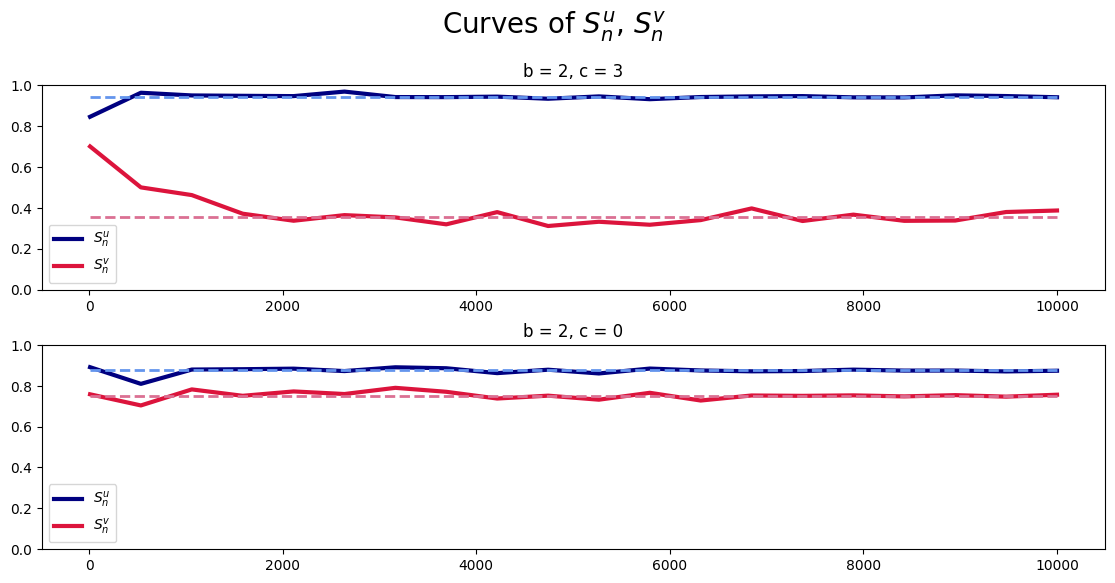

In [ ]:
n_min = 10
n_max = 10000
consts = [(2, 3), (2, 0)]
u = {1, 2, 3}
v = {1, 2}
plot_width = 12.
plot_height = 6.

theory_val = [(0.941, 0.353), (0.875, 0.75)]

plot_snu_snv(n_min, n_max, consts, u, v, plot_width, plot_height, theory_val)


Les courbes sont cohérentes avec les résultats selon lesquels les estimateurs convergent presque sûrement vers $(S_u, S_v)$.
Chaque courbe "converge visuellement" vers une valeur fixe comprise entre 0 et 1. Les lignes en pointillés montrent les valeurs théoriques $S_u$ et $S_v$ et les estimateurs s'en approchent assymptotiquement.

**$S_4$.** Créer un code python permettant d’estimer la matrice de covariance $\Gamma$. Calculer cet estimateur sur la même fonction. Dans la suite on notera $\widehat{\Gamma}$ cet estimateur.

In [ ]:
def calc_z(y: float, y_u: float, y_v: float) -> np.ndarray:
    return np.array([y, y_u, y_v, y*y_u, y*y_v, y**2])

def calc_zs(ys: np.ndarray, ys_u: np.ndarray, ys_v: np.ndarray) -> np.ndarray:
    return np.array([calc_z(y, y_u, y_v) for y, y_u, y_v in zip(ys, ys_u, ys_v)])

def estimate_cov_z(zs: np.ndarray) -> np.ndarray:
    return np.cov(zs.T)

def estimate_m_z(zs: np.ndarray) -> np.ndarray:
    return np.mean(zs, axis=0)

def calc_jacobian_phi(x: np.ndarray) -> np.ndarray:
    assert x.size == 6
    return np.array([
        [(-x[1]*(x[5] - x[0]**2) + 2*x[0]*(x[3] - x[0]*x[1]))/(x[5] - x[0]**2)**2, -x[0]/(x[5] - x[0]**2), 0, 1/(x[5] - x[0]**2), 0, (x[0]*x[1] - x[3])/(x[5] - x[0]**2)**2],
        [(-x[2]*(x[5] - x[0]**2) + 2*x[0]*(x[4] - x[0]*x[2]))/(x[5] - x[0]**2)**2, 0, -x[0]/(x[5] - x[0]**2), 0, 1/(x[5] - x[0]**2), (x[0]*x[2] - x[4])/(x[5] - x[0]**2)**2]
    ])

# Estimator de \hat{\Gamma}
def estimate_cov_su_sv(ys: np.ndarray, ys_u: np.ndarray, ys_v: np.ndarray) -> np.ndarray:
    zs = calc_zs(ys, ys_u, ys_v)

    sigma = estimate_cov_z(zs)
    m = estimate_m_z(zs)
    jac = calc_jacobian_phi(m)
    return jac@sigma@jac.T

# Estimator de \hat{\sigma^2}
def estimate_var_diff_su_sv(ys: np.ndarray, ys_u: np.ndarray, ys_v: np.ndarray) -> float:
    cov_mat = estimate_cov_su_sv(ys, ys_u, ys_v)
    aux = np.array([1., -1.])
    return aux@cov_mat@aux.T

**$S_5$.** Créer un code python permettant de calculer $N = 10^3$ valeur distinctes de la quantité $\sqrt{n}(S_n^u - S_n^v)$ pour $n = 10^3$. Tracer les histogrammes de ces $N$ valeurs pour la fonction précédentes pour les 2 choix de $b$ et $c$. Que remarque t-on?

In [ ]:
def simulate_su_sv(n:int, N:int, b: float, c: float, u: set, v:set) -> tuple[np.ndarray, np.ndarray, float]:
    func = lambda x, x_prime, u: func_f(x, b, c, x_prime, u)
    ss_nu = []
    ss_nv = []
    all_ys = np.array([])
    all_ys_u = np.array([])
    all_ys_v = np.array([])
    for _ in range(N):
        xs, xs_prime = get_x_samples(n, len_x=4, theta0=0)
        ys = calc_ys(xs, func)
        ys_u = calc_ys_u(xs, xs_prime, func, u)
        ys_v = calc_ys_u(xs, xs_prime, func, v)
        ss_nu.append(estimateur_s(ys, ys_u))
        ss_nv.append(estimateur_s(ys, ys_v))
        all_ys = np.concatenate((all_ys, ys))
        all_ys_u = np.concatenate((all_ys_u, ys_u))
        all_ys_v = np.concatenate((all_ys_v, ys_v))
    ss_nu = np.array(ss_nu)
    ss_nv = np.array(ss_nv)
    est_var = estimate_var_diff_su_sv(all_ys, all_ys_u, all_ys_v)
    return ss_nu, ss_nv, est_var

def plot_distr_snu_snv(n: int, N: int, consts: List[tuple[float, float]], u: set, v:set, plot_width: float, plot_height: float) -> None:
    fig, axs = plt.subplots(1, len(consts))
    fig.suptitle("Histograms of $\\sqrt{n}(S_n^u - S_n^v)$", size=20)
    fig.tight_layout()
    fig.set_size_inches(plot_width, plot_height)

    for i, const in enumerate(consts):
        b, c = const
        ss_nu, ss_nv, _ = simulate_su_sv(n, N, b, c, u, v)
        data = np.sqrt(n)*(ss_nu - ss_nv)
        counts, bins = np.histogram(data, bins=20)
        axs[i].stairs(counts, bins, fill=True, label="simulation", color="navy")
        axs[i].set_title(f"b = {b}, c = {c}")

    plt.show()

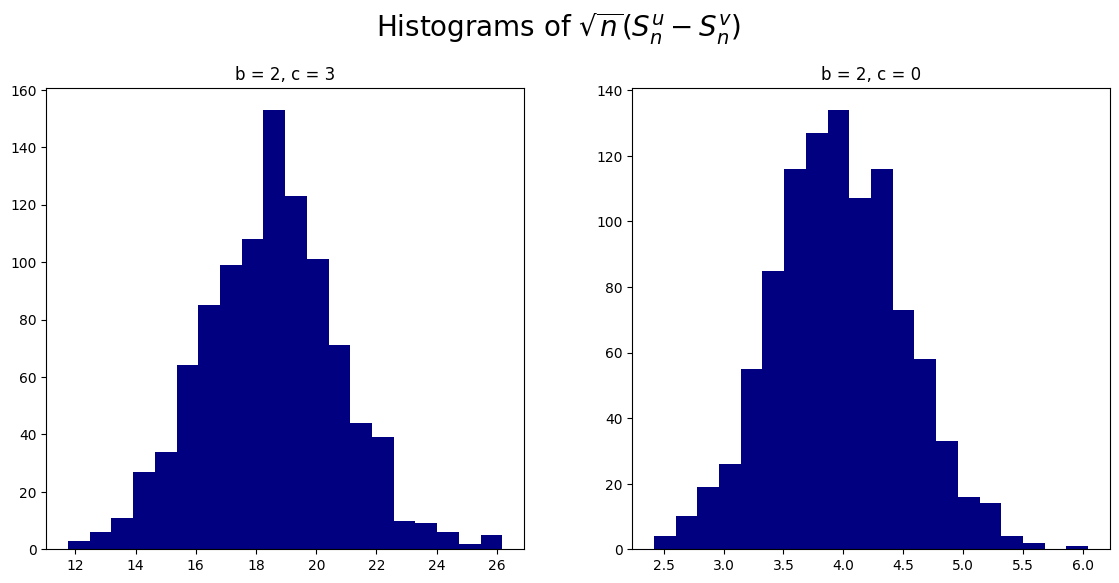

In [ ]:
n = 1000
N = 1000
consts = [(2, 3), (2, 0)]
u = {1, 2, 3}
v = {1, 2}
plot_width = 12.
plot_height = 6.

plot_distr_snu_snv(n, N, consts, u, v, plot_width, plot_height)

Selon la théorie, $\sqrt{n}(S_n^u - S_n^v)$ converge assympotiquement vers une gaussienne. On remarque qu'on a une forme que ressemble une gaussienne, comme on espèrait. Lorsque $S_u \neq S_v$, la gaussienne n'est pas centrée. Alors, on attende une moyen égal à $\sqrt{n}(S_u - S_v)$.

Pour $n = 1000$, $b=2$ et $c=3$, $\sqrt{n}(S_u - S_v) = 18.6$.

Pour $n = 1000$, $b=2$ et $c=0$, $\sqrt{n}(S_u - S_v) = 3.95$.

Ce qui est compatible avec les résultats du experiment.

**$S_6$.** Créer un code python permettant de calculer un estimateur $\widehat{\sigma^2}$ consistant de $\sigma^2$ et reprendre la question précédente en remplaçant $\sqrt{n}(S_n^u - S_n^v)$ par $\frac{\sqrt{n}(S_n^u - S_n^v)}{\widehat{\sigma^2}}$. Que remarque t-on?

In [ ]:
def norm_dist_pdf(mean: float, var: float, start: float, end:float, scale: float=1.) -> tuple[np.ndarray, np.ndarray]:
    """Calculates the x and y axis of the probability density function of a normal distribution

    Args:
        mean (float): mean
        var (float): variance
        start (float): Start of x axis.
        end (float): End of x axis.
        scale (float, optional): Scaling factor. Defaults to 1.0.

    Returns:
        Tuple[np.ndarray, np.ndarray]: x and y axis of the probability mass function
    """
    x = np.linspace(start, end)
    
    y = scale*norm.pdf(x, mean, np.sqrt(var))
    return x, y

def plot_distr_snu_snv_normalized(n: int, N: int, consts: List[tuple[float, float]], theory_vals: List[tuple[float, float]], u: set, v:set, plot_width: float, plot_height: float) -> None:
    fig, axs = plt.subplots(1, len(consts))
    fig.suptitle("Histograms of $\\frac{\\sqrt{n}(S_n^u - S_n^v)}{\\widehat{\\sigma^2}}$", size=20)
    fig.tight_layout()
    fig.set_size_inches(plot_width, plot_height)

    for i, const in enumerate(consts):
        b, c = const
        su, sv = theory_vals[i]
        ss_nu, ss_nv, var = simulate_su_sv(n, N, b, c, u, v)
        data = np.sqrt(n/var)*(ss_nu - ss_nv)
        counts, bins = np.histogram(data, bins=20)
        axs[i].stairs(counts, bins, fill=True, label="simulation", color="navy")
        axs[i].set_title(f"b = {b}, c = {c}")

        axs[i].plot(
                *norm_dist_pdf(np.sqrt(n/var)*(su - sv), 1, min(data), max(data), np.sum(counts)*(bins[1] - bins[0])),
                label="theory", color="crimson", linestyle="dashed", linewidth=3
            )
        
        axs[i].legend(loc="upper left")

    plt.show()

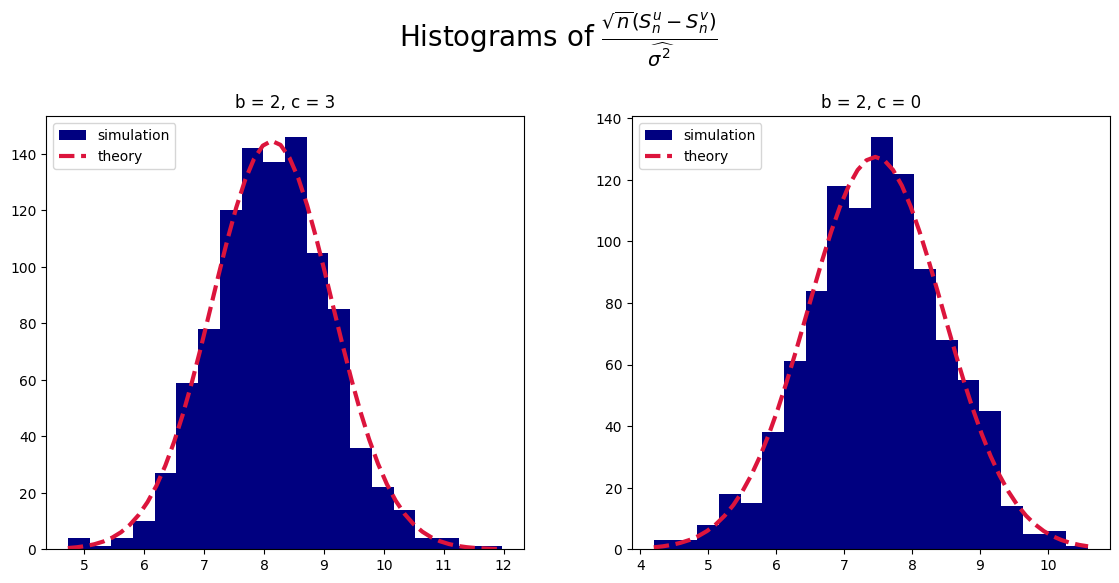

In [ ]:
n = 1000
N = 1000
consts = [(2, 3), (2, 0)]
theory_val = [(0.941, 0.353), (0.875, 0.75)]
u = {1, 2, 3}
v = {1, 2}
plot_width = 12.
plot_height = 6.


plot_distr_snu_snv_normalized(n, N, consts, theory_val, u, v, plot_width, plot_height)

Dans ce cas, comme on a divisé par l'écart-type, $\frac{\sqrt{n}(S_n^u - S_n^v)}{\widehat{\sigma^2}}$ converge en loi vers une gaussienne réduite. Encore, comme $S_u \neq S_v$, la gaussienne n'est pas centrée, mais on a sa moyen qui est égal à $\frac{\sqrt{n}(S_u - S_v)}{\widehat{\sigma^2}}$. Alors, on a sa loi qui est la ligne pointillée.

On voit que les résultats experimenteaux sont très proches de la distribuition assymptotique théorique.

**$S_7$.** Créer un code python permettant pour $n = 500$ et pour les 2 choix de $b$ et $c$ de la question $S_2$

1. de calculer $N = 1000$ valeurs de $T_K$,

1. de compter le nombre de fois où $T_K = 1$, on notera $N_K(n)$ ce nombre.

Ces résultats sont ils cohérents avec la théorie?

In [ ]:
def get_optimal_k(alpha:float, est_var:float, n:int) -> float:
    return np.sqrt(est_var/n)*phi_inv(alpha)

def decision_rule_k(dif:float, k:float):
    return 1 if dif < k else 0

def simulate_Nk(n:int, N:int, b:float, c:float, u:set, v:set, alpha:float, theory_val:tuple[float, float]|None = None) -> int:
    ss_nu, ss_nv, var = simulate_su_sv(n, N, b, c, u, v)
    difs = ss_nu - ss_nv
    k = get_optimal_k(alpha, var, n)
    return sum(decision_rule_k(dif, k) for dif in difs)



In [ ]:
n = 500
N = 1000
alpha = 0.05

u = {1, 2, 3}
v = {1, 2}

consts = [(2, 3), (2, 0)]
for i, const in enumerate(consts):
    b, c = const
    Nk = simulate_Nk(n, N, b, c, u, v, alpha)
    print(f"For b={b}, c={c}: Nk={Nk}")

For b=2, c=3: Nk=0
For b=2, c=0: Nk=0


Comme $S_u \neq S_v$, on n'est pas sur $H_0$. Alors, on doit choisir $H_1$. $N_K = 0$, c'est à dire qu'on l'a choisi tous les fois, ce qui est cohérent avec la théorie.

**$S_8$.** Reprendre le code de la question précédente en faisant varier $n$ de $100$ à $5000$ et tracer en fonction de $n$ les 2 courbes $n \mapsto N_K(n)$. Que remarquez vous?

In [ ]:
def plot_nk(n_min:int, n_max:int, N:int, alpha:float, consts: List[tuple[float, float]], u: set, v:set,
            plot_width: float, plot_height: float) -> None:
    fig, axs = plt.subplots(len(consts))
    fig.suptitle("Curves of $N_K$", size=20)
    fig.tight_layout()
    fig.set_size_inches(plot_width, plot_height)

    for i, const in enumerate(consts):
        b, c = const
        ns = np.linspace(n_min, n_max, dtype=np.int64, num=5)
        Nk = [simulate_Nk(n, N, b, c, u, v, alpha) for n in ns]
        axs[i].set_title(f"b = {b}, c = {c}")
        axs[i].plot(ns, Nk, label="$N_K$", color="indigo", linewidth=3)
        axs[i].legend()

    plt.show()

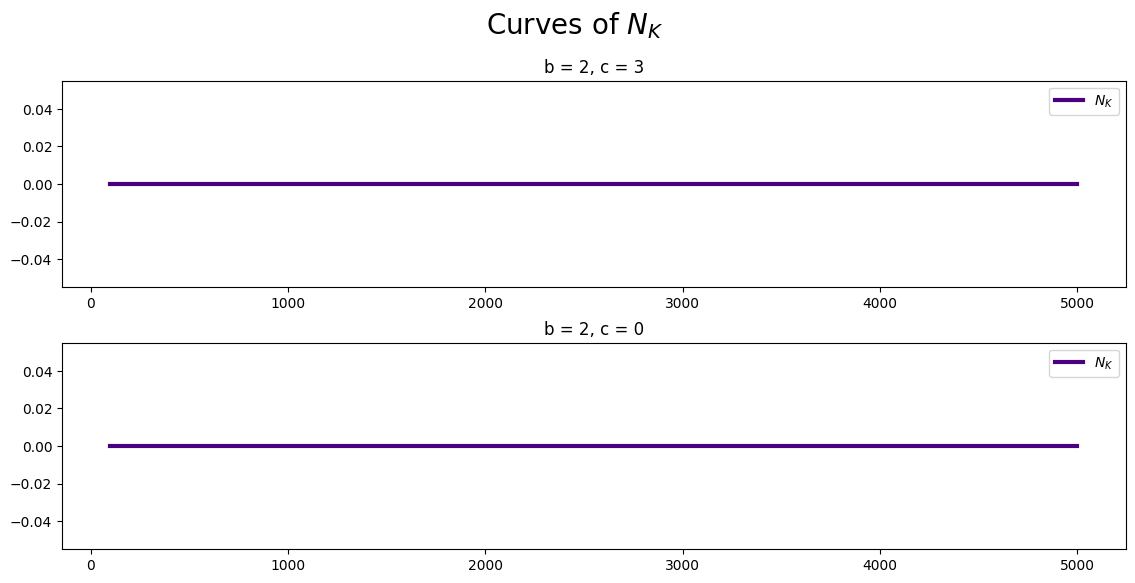

In [ ]:
n_min = 100
n_max = 5000
N = 1000
alpha = 0.05
consts = [(2, 3), (2, 0)]
u = {1, 2, 3}
v = {1, 2}

plot_width = 12.
plot_height = 6.

plot_nk(n_min, n_max, N, alpha, consts, u, v, plot_width, plot_height)

On remarque qu'on choisi $H_1$ toujours, saus rarement pour $n$ petit. Alors, la courbe n'est pas très intéressante et son comportament est expliqué pour ce qu'on a dit à $S_7$.